<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepNLP-END2.0/blob/main/14_BERT_BART/BERT_Tutorial_How_To_Build_a_Question_Answering_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
! nvidia-smi

Wed Aug 11 20:57:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    72W / 149W |    122MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install huggingface libraries
! pip install pytorch-pretrained-bert==0.6.2 pytorch-nlp==0.5.0 pytorch_transformers==1.2.0

     |████████████████████████████████| 123 kB 4.2 MB/s 
     |████████████████████████████████| 90 kB 6.4 MB/s 
     |████████████████████████████████| 176 kB 19.0 MB/s 
     |████████████████████████████████| 131 kB 32.5 MB/s 
     |████████████████████████████████| 895 kB 32.4 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 7.8 MB 36.8 MB/s 
     |████████████████████████████████| 138 kB 47.1 MB/s 
     |████████████████████████████████| 127 kB 43.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.

Restart the Runtime !

In [ ]:
! git clone https://github.com/nlpyang/pytorch-transformers && cd pytorch-transformers && git checkout e00b4ff1de0591d5093407b16e665e5c86028f04

Cloning into 'pytorch-transformers'...
remote: Enumerating objects: 6469, done.
remote: Total 6469 (delta 0), reused 0 (delta 0), pack-reused 6469
Receiving objects: 100% (6469/6469), 3.60 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (4637/4637), done.
Note: checking out 'e00b4ff1de0591d5093407b16e665e5c86028f04'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at e00b4ff fix #1017


In [ ]:
! git clone https://github.com/chrischute/squad && cd squad && git checkout 85623adeb9e6639f145081fea9cae2d8f3a26379

Cloning into 'squad'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.
Note: checking out '85623adeb9e6639f145081fea9cae2d8f3a26379'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 85623ad Update Miniconda URL in README.md


In [ ]:
import sys
if 'pytorch-transformers/examples' not in sys.path: print('adding squad utils to path') ; sys.path.insert(0, 'pytorch-transformers/examples')

adding squad utils to path


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm.auto import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = 'squad/data/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
19649,56e7921a37bdd419002c4171,what is one reason that caused the island to b...,"[The, islands, were, occupied, by, a, garrison...",the opening of the Suez Canal,35,40,False
19650,5ad3c98e604f3c001a3ff09f,By who was the sailing ships occupied?,"[The, islands, were, occupied, by, a, garrison...",,-1,-1,True
19651,5ad3c98e604f3c001a3ff0a0,Who used the islands as a base in the Northern...,"[The, islands, were, occupied, by, a, garrison...",,-1,-1,True
19652,5ad3c98e604f3c001a3ff0a1,Which canal was opened in 1689?,"[The, islands, were, occupied, by, a, garrison...",,-1,-1,True
19653,5ad3c98e604f3c001a3ff0a2,What decreased isolation in the islands?,"[The, islands, were, occupied, by, a, garrison...",,-1,-1,True
19654,5ad3c98e604f3c001a3ff0a3,When was the East Asia canal opened?,"[The, islands, were, occupied, by, a, garrison...",,-1,-1,True


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
Accordingly, leaving Field Marshal Count Kurt von Schwerin in Silesia with 25,000 soldiers to
guard against incursions from Moravia or Hungary, and leaving Field Marshal Hans von Lehwaldt
in East Prussia to guard against Russian invasion from the east, Frederick set off
with his army for Saxony. The Prussian army marched in three columns. On the
right was a column of about 15,000 men under the command of Prince Ferdinand
of Brunswick. On the left was a column of 18,000 men under the command
of the Duke of Brunswick-Bevern. In the centre was Frederick II, himself with Field
Marshal James Keith commanding a corps of 30,000 troops. Ferdinand of Brunswick was to
close in on the town of Chemnitz. The Duke of Brunswick-Bevern was to traverse
Lusatia to close in on Bautzen. Meanwhile, Frederick and Field Marshal Keith would make
for Dresden.
QUESTION:                                                                                            ANSWER:
How did Frederick protect Silesia 

In [ ]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
115258,5733bc38d058e614000b618a,Which two antibiotics that have high efficacy ...,"[The, emergence, of, resistance, of, bacteria,...",penicillin and erythromycin,89,91,False,118,71
54645,5726747e708984140094c6c1,What rank does Greece hold for the condition o...,"[Greece, has, universal, health, care., In, a,...",19th,36,36,False,141,76
48800,5ace586232bba1001ae4a34a,What did spanish scientist Joseph Nicéphore Ni...,"[Bitumen, was, used, in, early, photographic, ...",,-1,-1,True,114,95
109467,5a8c42cdfd22b3001a8d866e,How is data in an optional table removed?,"[Linking, the, information, back, together, is...",,-1,-1,True,100,41
116754,57312d4da5e9cc1400cdbccb,What territory was Vladimar Prince of before h...,"[Vladimir, had, been, prince, of, Novgorod, wh...",Novgorod,5,5,False,266,61


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = 'cache_train'

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0065,  0.0218, -0.0105,  ..., -0.0194, -0.0125,  0.0271],
        [-0.0134, -0.0046, -0.0162,  ..., -0.0086,  0.0108,  0.0174]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1
fraction_per_epoch = 0.2

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // (num_train_epochs * fraction_per_epoch)))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

train_dataset_fraction = torch.utils.data.Subset(dataset, list(range(0, round(len(dataset) * fraction_per_epoch))))
train_dataloader_fraction = DataLoader(train_dataset_fraction, batch_size=batch_size, drop_last=True)

for _ in train_iterator:
    epoch_iterator = tqdm(iter(train_dataloader_fraction), desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 45079


/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.682131371960044
Saving model checkpoint to checkpoint-1000




In [ ]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('checkpoint-1000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

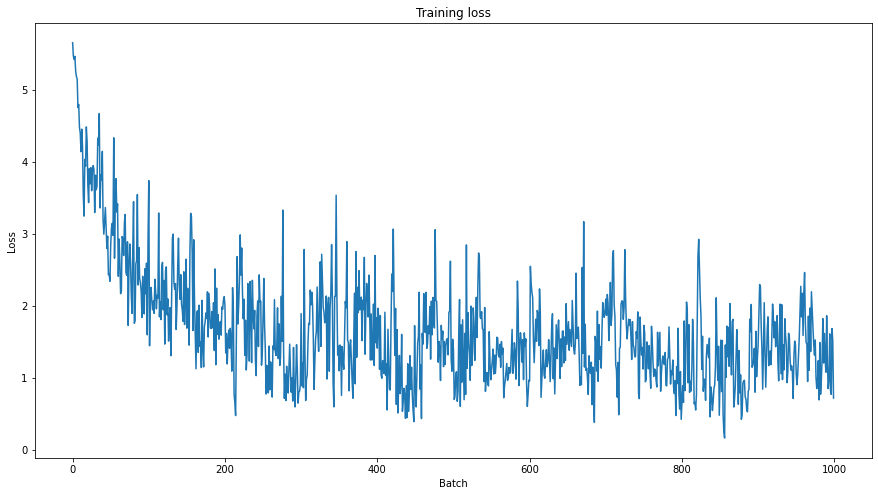

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = 'squad/data/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=False)

**Evaluate test dataset**

In [ ]:
print("***** Running evaluation *****")
print("  Num examples = %d" % len(dataset))
print("  Batch size = %d" % batch_size)
all_results = []
predict_file = 'squad/data/dev-v2.0.json'
for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
        example_indices = batch[3]
        outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
        eval_feature = features[example_index.item()]
        unique_id = int(eval_feature.unique_id)

        result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
        all_results.append(result)

***** Running evaluation *****
  Num examples = 7205
  Batch size = 16


In [ ]:
len(all_results), len(features)

(7205, 7205)

In [ ]:
# Compute predictions
output_prediction_file = "predictions.json"
output_nbest_file = "nbest_predictions.json"
output_null_log_odds_file = "null_odds.json"

In [ ]:
write_predictions(val_examples, features, all_results, 10,
                30, True, output_prediction_file,
                output_nbest_file, output_null_log_odds_file, False,
                True, 0.0)

In [ ]:
# Evaluate with the official SQuAD script
evaluate_options = EVAL_OPTS(data_file=predict_file,
                            pred_file=output_prediction_file,
                            na_prob_file=output_null_log_odds_file,
                            out_image_dir=None)
results = evaluate_on_squad(evaluate_options)

{
  "exact": 59.230009871668315,
  "f1": 61.210163805868284,
  "total": 6078,
  "HasAns_exact": 45.49828178694158,
  "HasAns_f1": 49.634149694868604,
  "HasAns_total": 2910,
  "NoAns_exact": 71.84343434343434,
  "NoAns_f1": 71.84343434343434,
  "NoAns_total": 3168,
  "best_exact": 59.493254359986835,
  "best_exact_thresh": -0.10016250610351562,
  "best_f1": 61.38637161248114,
  "best_f1_thresh": -0.08133554458618164
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 59.230009871668315}, {'f1': 61.210163805868284}, {'total': 6078}, {'HasAns_exact': 45.49828178694158}, {'HasAns_f1': 49.634149694868604}, {'HasAns_total': 2910}, {'NoAns_exact': 71.84343434343434}, {'NoAns_f1': 71.84343434343434}, {'NoAns_total': 3168}, {'best_exact': 59.493254359986835}, {'best_exact_thresh': -0.10016250610351562}, {'best_f1': 61.38637161248114}, {'best_f1_thresh': -0.08133554458618164}]


**Evaluate on any text**

In [ ]:
with open('predictions.json') as f:
    best_predictions = json.load(f)

In [ ]:
import random

for example in random.sample(val_examples, 40):
    qas_id = example.qas_id
    question_text = example.question_text
    answer_text = best_predictions[qas_id]

    print(f'question       >> {question_text}')
    print(f'model\'s answer >> {answer_text}')

    print()

question       >> What was developed from Watt's measurements on an atmospheric concept?
model's answer >> 

question       >> How does HT strive to give up power?
model's answer >> through "ideological struggle

question       >>  What was the Yuan's Persian enemy?
model's answer >> 

question       >> Why did Harvard end its early admission program?
model's answer >> 

question       >> When did Kublai ban the international Mongol slave trade?
model's answer >> 1291

question       >> What is the mayor of Warsaw called?
model's answer >> President

question       >> In what geographical portion of England is Abercynon located?
model's answer >> south Wales

question       >>  When Iqbal promoted ideas of greater Islamic political unity, what did he discourage ending?
model's answer >> 

question       >> At what age do immune responses typically begin to decline?
model's answer >> 

question       >> What is the "hand shake" between communication parties?
model's answer >> 

question